In [1]:
#@title hyperparams
model_checkpoint = "yeeb/bert-base-cased_C50" #@param {type:"string"}
max_length = 512 #@param {type:"number"}
learning_rate = 2e-5 #@param {type:"number"}
num_epochs = 10 #@param {type:"number"}
train_batch_size = 16 #@param {type:"number"}
eval_batch_size = 32 #@param {type:"number"}
valid_frac = 0.1 #@param {type:"number"}
seed = 42 #@param {type:"number"}

hyperparameters = {
    "learning_rate": learning_rate,
    "num_epochs": num_epochs,
    "train_batch_size": train_batch_size,
    "eval_batch_size": eval_batch_size,
    "seed": seed,
    "valid_frac": valid_frac,
}

In [2]:
!pip install datasets transformers
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install git+https://github.com/huggingface/accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 15.7 MB/s 
     |████████████████████████████████| 5.3 MB 50.5 MB/s 
     |████████████████████████████████| 163 kB 57.4 MB/s 
     |████████████████████████████████| 212 kB 68.5 MB/s 
     |████████████████████████████████| 115 kB 67.0 MB/s 
     |████████████████████████████████| 127 kB 51.9 MB/s 
     |████████████████████████████████| 7.6 MB 7.2 MB/s 
     |████████████████████████████████| 115 kB 59.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-6t23o9tp
  Running command git clone -q https://github.com/huggingface/accelerate /tmp/pip-req-build-6t23o

In [3]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 23.2 MB/s 


In [4]:
%%capture
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00217/C50.zip
!unzip -of C50

### code

In [5]:
from os import listdir
from os.path import isfile, isdir, join
import numpy as np

author_names = [name for name in listdir('C50train/') if isdir(join('C50train/', name))]
print('There are', len(author_names), 'authors (both train and test), the first 3:', author_names[:3])

train_article_names = [[article_name for article_name in listdir('C50train/' + author_name + '/') if isfile(join('C50train/' + author_name + '/', article_name))]
                  for author_name in author_names]
print('There are', len(train_article_names[0]), '(train) articles written by the first author')
test_article_names = [[article_name for article_name in listdir('C50test/' + author_name + '/') if isfile(join('C50test/' + author_name + '/', article_name))]
                  for author_name in author_names]
print('There are', len(test_article_names[0]), '(test) articles written by the first author')

train_articles = np.empty((2500, 2), dtype=object)
for i, author_name in enumerate(author_names):
  for j, article_name in enumerate(train_article_names[i]):
    file_path = 'C50train/' + author_name + '/' + article_name
    with open(file_path, 'r') as f:
      train_articles[i * len(author_names) + j, 0] = author_name
      train_articles[i * len(author_names) + j, 1] = f.read()
print('The shape of train articles is', train_articles.shape)

test_articles = np.empty((2500, 2), dtype=object)
for i, author_name in enumerate(author_names):
  for j, article_name in enumerate(test_article_names[i]):
    file_path = 'C50test/' + author_name + '/' + article_name
    with open(file_path, 'r') as f:
      test_articles[i * len(author_names) + j, 0] = author_name
      test_articles[i * len(author_names) + j, 1] = f.read()
print('The shape of test articles is', test_articles.shape)

There are 50 authors (both train and test), the first 3: ['MarkBendeich', 'SimonCowell', 'TimFarrand']
There are 50 (train) articles written by the first author
There are 50 (test) articles written by the first author
The shape of train articles is (2500, 2)
The shape of test articles is (2500, 2)


In [6]:
# get the data in a format for the train script
import pandas as pd
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

total = pd.DataFrame(data=np.concatenate([train_articles, test_articles]), columns=['labels','text'])
# train = pd.DataFrame(data=train_articles, columns=['labels','text'])
# test = pd.DataFrame(data=test_articles, columns=['labels','text'])

train = total.sample(frac=.9, random_state=42)
test = total.drop(train.index)

train['labels'] = label_encoder.fit_transform(train['labels'])

valid = train.sample(frac=hyperparameters["valid_frac"], random_state=hyperparameters["seed"])
train = train.drop(valid.index)

train.to_csv('/content/train.csv', index=False)
valid.to_csv('/content/valid.csv', index=False)

test['labels'] = label_encoder.transform(test['labels'])
test.to_csv('/content/test.csv', index=False)

del train
del valid
del test

In [7]:
# adapted from https://github.com/huggingface/notebooks/blob/main/examples/accelerate_examples/simple_nlp_example.ipynb
import torch
from torch.utils.data import DataLoader

from accelerate import Accelerator, DistributedType
from datasets import load_dataset, load_metric
from transformers import (
    AdamW,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
)

from tqdm.auto import tqdm

import datasets
import transformers

In [8]:
raw_datasets = load_dataset(
    "csv",
    data_files={'train': 'train.csv', 'validation': 'valid.csv',  'test': 'test.csv'}
)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-820543a91e7a1c42/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')#model_checkpoint)
tokenize_function = lambda ex: tokenizer(ex["text"], truncation=True, padding="max_length", max_length=max_length)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True, remove_columns="text")
tokenized_datasets["train"].features

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

{'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [11]:
tokenized_datasets.set_format("torch")

In [12]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=50)

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [13]:
def create_dataloaders(train_batch_size=16, eval_batch_size=32):
    train_dataloader = DataLoader(
        tokenized_datasets["train"], shuffle=True, batch_size=train_batch_size
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["validation"], shuffle=False, batch_size=eval_batch_size
    )
    test_dataloader = DataLoader(
        tokenized_datasets["test"], shuffle=False, batch_size=eval_batch_size
    )
    return train_dataloader, eval_dataloader, test_dataloader

In [14]:
accuracy = load_metric("accuracy")
f1 = load_metric("f1")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


In [13]:
def training_function(model):
    # Initialize accelerator
    accelerator = Accelerator()

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    train_dataloader, eval_dataloader, test_dataloader = create_dataloaders(
        train_batch_size=hyperparameters["train_batch_size"], eval_batch_size=hyperparameters["eval_batch_size"]
    )
    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Instantiate optimizer
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=hyperparameters["learning_rate"])

    # Prepare everything
    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    model, optimizer, train_dataloader, eval_dataloader, test_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader, test_dataloader
    )

    num_epochs = hyperparameters["num_epochs"]
    # Instantiate learning rate scheduler after preparing the training dataloader as the prepare method
    # may change its length.
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=100,
        num_training_steps=len(train_dataloader) * num_epochs,
    )

    # Instantiate a progress bar to keep track of training. Note that we only enable it on the main
    # process to avoid having 8 progress bars.
    progress_bar = tqdm(range(num_epochs * len(train_dataloader)), disable=not accelerator.is_main_process)
    # Now we train the model
    for epoch in range(num_epochs):
        model.train()
        for step, batch in enumerate(train_dataloader):
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)
            
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        model.eval()
        all_predictions = []
        all_labels = []

        for step, batch in enumerate(eval_dataloader):
            with torch.no_grad():
                outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)

            # We gather predictions and labels from the 8 TPUs to have them all.
            all_predictions.append(accelerator.gather(predictions))
            all_labels.append(accelerator.gather(batch["labels"]))

        # Concatenate all predictions and labels.
        # The last thing we need to do is to truncate the predictions and labels we concatenated
        # together as the prepared evaluation dataloader has a little bit more elements to make
        # batches of the same size on each process.
        all_predictions = torch.cat(all_predictions)[:len(tokenized_datasets["validation"])]
        all_labels = torch.cat(all_labels)[:len(tokenized_datasets["validation"])]

        accuracy_metric = accuracy.compute(predictions=all_predictions, references=all_labels)
        f1_metric = f1.compute(predictions=all_predictions, references=all_labels, average='micro')

        # Use accelerator.print to print only on the main process.
        accelerator.print(f"epoch {epoch}, validation metrics:", accuracy_metric, f1_metric)


    ########## run test eval
    model.eval()
    all_predictions = []
    all_labels = []

    for step, batch in enumerate(test_dataloader):
        with torch.no_grad():
            outputs = model(**batch)
        predictions = outputs.logits.argmax(dim=-1)

        # We gather predictions and labels from the 8 TPUs to have them all.
        all_predictions.append(accelerator.gather(predictions))
        all_labels.append(accelerator.gather(batch["labels"]))

    # Concatenate all predictions and labels.
    # The last thing we need to do is to truncate the predictions and labels we concatenated
    # together as the prepared evaluation dataloader has a little bit more elements to make
    # batches of the same size on each process.
    all_predictions = torch.cat(all_predictions)[:len(tokenized_datasets["test"])]
    all_labels = torch.cat(all_labels)[:len(tokenized_datasets["test"])]

    accuracy_metric = accuracy.compute(predictions=all_predictions, references=all_labels)
    f1_metric = f1.compute(predictions=all_predictions, references=all_labels, average='micro')

    # Use accelerator.print to print only on the main process.
    accelerator.print(f"test metrics:", accuracy_metric, f1_metric)


### run training

In [14]:
from accelerate import notebook_launcher

notebook_launcher(training_function, (model,))

Launching training on one GPU.


  0%|          | 0/2540 [00:00<?, ?it/s]

epoch 0, validation metrics: {'accuracy': 0.5377777777777778} {'f1': 0.5377777777777778}
epoch 1, validation metrics: {'accuracy': 0.6688888888888889} {'f1': 0.6688888888888889}
epoch 2, validation metrics: {'accuracy': 0.7044444444444444} {'f1': 0.7044444444444444}
epoch 3, validation metrics: {'accuracy': 0.7422222222222222} {'f1': 0.7422222222222222}
epoch 4, validation metrics: {'accuracy': 0.7644444444444445} {'f1': 0.7644444444444445}
epoch 5, validation metrics: {'accuracy': 0.7777777777777778} {'f1': 0.7777777777777778}
epoch 6, validation metrics: {'accuracy': 0.7955555555555556} {'f1': 0.7955555555555557}
epoch 7, validation metrics: {'accuracy': 0.7955555555555556} {'f1': 0.7955555555555557}
epoch 8, validation metrics: {'accuracy': 0.8066666666666666} {'f1': 0.8066666666666665}
epoch 9, validation metrics: {'accuracy': 0.8044444444444444} {'f1': 0.8044444444444445}
test metrics: {'accuracy': 0.796} {'f1': 0.796}


In [17]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [18]:
model.push_to_hub("bert-base-cased_C50")

Configuration saved in /tmp/tmpgl3ekk53/config.json
Model weights saved in /tmp/tmpgl3ekk53/pytorch_model.bin
Uploading the following files to yeeb/bert-base-cased_C50: pytorch_model.bin,config.json


CommitInfo(commit_url='https://huggingface.co/yeeb/bert-base-cased_C50/commit/d7412597591714557e0f0b0d27f8df775099efa5', commit_message='Upload BertForSequenceClassification', commit_description='', oid='d7412597591714557e0f0b0d27f8df775099efa5', pr_url=None, pr_revision=None, pr_num=None)

In [15]:
def eval_function(model, all_predictions, all_labels):
    accelerator = Accelerator()

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    train_dataloader, eval_dataloader, test_dataloader = create_dataloaders(
        train_batch_size=hyperparameters["train_batch_size"], eval_batch_size=hyperparameters["eval_batch_size"]
    )
    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    model, train_dataloader, eval_dataloader, test_dataloader = accelerator.prepare(
        model, train_dataloader, eval_dataloader, test_dataloader
    )

    model.eval()

    for step, batch in enumerate(test_dataloader):
        with torch.no_grad():
            outputs = model(**batch)
        predictions = outputs.logits.argmax(dim=-1)

        all_predictions.append(accelerator.gather(predictions))
        all_labels.append(accelerator.gather(batch["labels"]))

    all_predictions = torch.cat(all_predictions)[:len(tokenized_datasets["test"])]
    all_labels = torch.cat(all_labels)[:len(tokenized_datasets["test"])]

    accuracy_metric = accuracy.compute(predictions=all_predictions, references=all_labels)
    f1_metric = f1.compute(predictions=all_predictions, references=all_labels, average='micro')

    # Use accelerator.print to print only on the main process.
    accelerator.print(f"test metrics:", accuracy_metric, f1_metric)
    return all_predictions, all_labels

In [16]:
from accelerate import notebook_launcher

all_predictions = []
all_labels = []
notebook_launcher(eval_function, (model,all_predictions,all_labels))

Launching training on one CPU.
test metrics: {'accuracy': 0.954} {'f1': 0.954}


In [17]:
preds = torch.cat(all_predictions).cpu().numpy()
labels = torch.cat(all_labels).cpu().numpy()

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

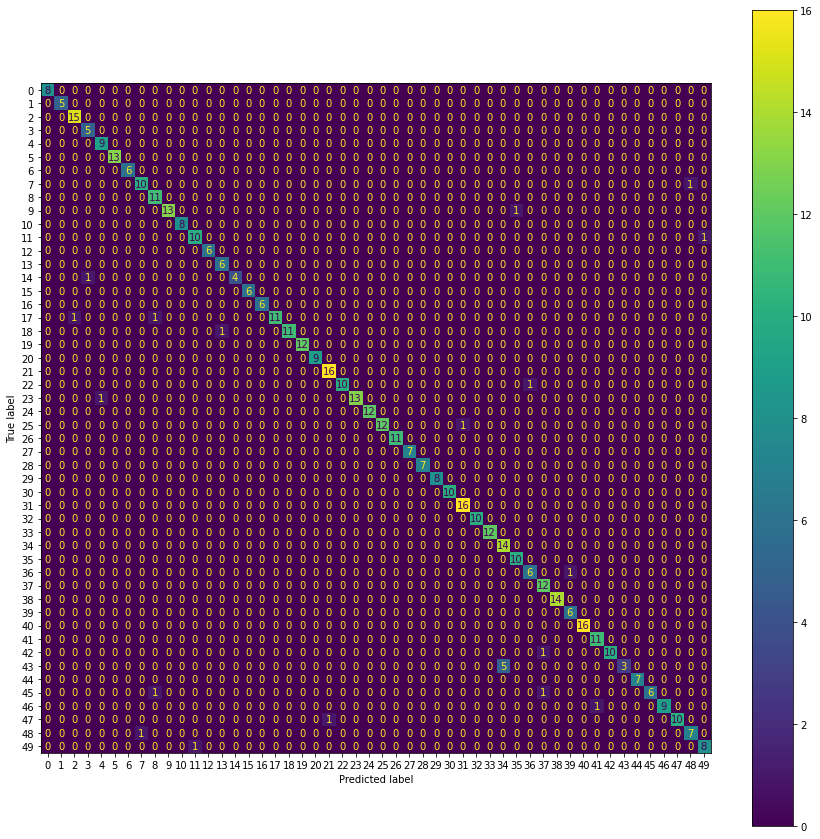

In [19]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)

In [20]:
wrong = np.where(preds != labels)[0]
right = np.where(preds == labels)[0][:len(wrong)]

In [21]:
wrong

array([100, 109, 132, 158, 170, 171, 172, 174, 175, 178, 180, 209, 217,
       240, 256, 264, 275, 287, 288, 365, 379, 403, 416])

In [22]:
right

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [51]:
labels[wrong]

array([25, 45, 46, 23, 43, 43, 43, 43, 43, 36, 14, 48, 22, 47,  9, 11, 49,
       17, 17, 45,  7, 42, 18])

In [23]:
test_df = pd.read_csv('test.csv')

In [24]:
test_df.iloc[wrong]['text'].iloc[0]

'Microsoft Corp said on Monday it had sent the final version of Office 97 -- a product that is expected to be its biggest revenue generator in 1997 -- to factories and will have it in stores within weeks.\nThe product, a package of Microsoft\'s top-selling business programs, is Microsoft\'s biggest new product since the release of Windows 95, and is expected by analysts to increase the company\'s revenue by about 15 to 20 percent this year.\nAbout half of Microsoft\'s $8 billion in revenue came from business applications last year.\n"People on the (Office 97) development team were jumping in the fountain this afternoon," just after Microsoft sent the final version to manufacturing, said Pete Higgins, Microsoft group vice president of applications.\nThe new version, which had been in development for more than two years, features better ties to the Internet, help tools that guide computer users through common tasks and a new component called Outlook, which manages computer users\' docume

In [26]:
preds[100], labels[100]

(31, 25)

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5, max_df=0.95, lowercase=False, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(test_df.iloc[wrong]['text'])
y = vectorizer.fit_transform(test_df[test_df['labels'].isin(labels[wrong])]['text'])

In [54]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [55]:
pca = PCA(n_components=2)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [56]:
pca_vecs = pca.fit_transform(y.toarray())
y0 = pca_vecs[:, 0]
y1 = pca_vecs[:, 1]

In [66]:
# df = test_df.iloc[wrong].copy()
clusters= ['wrong']*len(x0) + ['right']*len(y0)
d0 = np.concatenate([x0, y0])
d1 = np.concatenate([x1, y1])

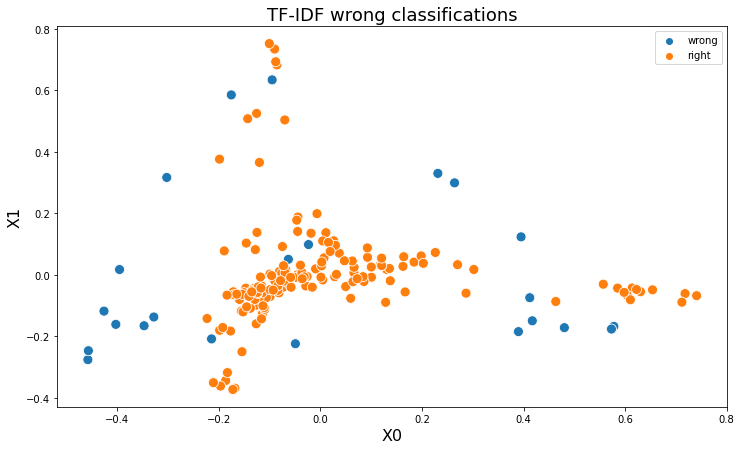

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.title("TF-IDF wrong classifications", fontdict={"fontsize": 18})
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
sns.scatterplot(x=d0, y=d1, hue=clusters, s=100)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5, max_df=0.95, lowercase=False, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(test_df.iloc[right]['text'])
y = vectorizer.fit_transform(test_df[test_df['labels'].isin(labels[right])]['text'])

In [ ]:
pca = PCA(n_components=2)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [94]:
from transformers import TextClassificationPipeline
import shap
class Pipeline(TextClassificationPipeline):
    def __call__(self, *args):
        print(args[0].device)
        out = super().__call__(args[0], self.set_labels)[0]
        return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])]]
    def set_labels(self, labels):
        self.set_labels = labels

In [97]:
# def func(text):
#     tokenized = tokenizer(text, truncation=True, padding="max_length", max_length=max_length, return_tensors='pt')
#     print(tokenized['input_ids'].to('cuda'))

In [108]:
# pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, truncation=True, padding="max_length", max_length=max_length, device=0)

text = test_df.iloc[wrong]['text'].iloc[0]

# func(text)

In [ ]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, truncation=True, padding="max_length", max_length=max_length, device=0)
explainer = shap.Explainer(pipe)
shap_values = explainer(text)

prediction = pipe(text)
print(f"Model predictions are: {prediction}")
shap.plots.text(shap_values)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Partition explainer: 3104it [13:08,  3.89it/s]


Model predictions are: [{'label': 'LABEL_38', 'score': 0.479669988155365}]


In [ ]:
# pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, truncation=True, padding="max_length", max_length=max_length, device=0)
# explainer = shap.Explainer(pipe)
text = test_df.iloc[right]['text'].iloc[0]

shap_values = explainer(text)

prediction = pipe(text)
print(f"Model predictions are: {prediction}")
shap.plots.text(shap_values)


### ignore

(attempt to get the example script to work out of the box)

!git clone https://github.com/huggingface/transformers.git
%cd /content/transformers
!git checkout tags/v4.22.2
!pip install .
%cd /content/transformers/examples/tensorflow/text-classification
!pip install -r requirements.txt

!pip install wandb
!wandb login

!python run_text_classification.py \
--train_file /content/train.csv \
--test_file /content/test.csv \
--max_seq_length 512 \
--pad_to_max_length \
--model_name_or_path bert-base-cased \
--tpu_num_cores 8 \
--output_dir /content/output/ \
--report_to all